## Imports

In [12]:
# Super Mario Bros env dependencies
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack, GrayScaleObservation, TransformObservation

# Torch
import torch
import torch.utils
import torch.nn as nn

# Networks to Evaluate
import sys, os
def add_to_path(model_dir):
    notebook_file = os.path.dirname("CNN_Feature_Visualisation.ipynb")
    path2add = os.path.normpath(os.path.abspath(os.path.join(notebook_file, os.path.pardir, model_dir)))
    if (not (path2add in sys.path)):
        print(f'updating path to include: {path2add}')
        sys.path.append(path2add)
add_to_path('DQN')
from OldAgent import MarioNet, Mario
add_to_path('a2c')
from a2c.model import ACNetwork

# CNN Visualisation (Lucent)
from lucent.optvis import render, param, transform, objectives
from lucent.misc.io import show
from lucent.modelzoo.util import get_model_layers

# Utilities
from utils.wrappers import ResizeObservation, SkipFrame
import utils.helper
from utils.config import Config
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import torch.utils
import torch._utils

## Model and Env Prep

In [13]:
def create_env(random = False, movement = SIMPLE_MOVEMENT):
    env_name = "SuperMarioBros"
    if random:
        env_name += "RandomStage"
    env_name += '-v3'
    env = gym_super_mario_bros.make(env_name)
    env = JoypadSpace(env, movement)
    return env, env_name

def run_model(env, steps, get_action, get_obs, image_dir):
    state = env.reset()
    frame = 0
    for step in range(steps):
        obs = get_obs(state)
        if len(obs.shape) == 3 and obs.shape[0] == 4:
                obs = np.concatenate(obs, axis=0) # if we have 4 inputs, we want them organised left to right
        Image.fromarray(obs).save(os.path.join(image_dir, f"frame_{frame}.png"))
        frame += 1

        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        
        if done:
            state = env.reset()

print(f"Is cuda supported on the system? {'Yes' if torch.cuda.is_available() else 'No'}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Is cuda supported on the system? Yes


## Setup Feature Visualisation Functions

In [35]:
# Code derived from: https://colab.research.google.com/github/greentfrapp/lucent-notebooks/blob/master/notebooks/feature_inversion.ipynb#scrollTo=d47pkOPKvNjs
@objectives.wrap_objective()
def dot_compare(layer, batch=1, cossim_pow=0):
    def inner(T):
        dot = (T(layer)[batch] * T(layer)[0]).sum()
        mag = torch.sqrt(torch.sum(T(layer)[0]**2))
        cossim = dot/(1e-6 + mag)
        return -dot * cossim ** cossim_pow
    return inner

transforms = [
    transform.pad(8, mode='constant', constant_value=.5),
    transform.jitter(8),
    transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
    transform.random_rotate(list(range(-5, 5)) + [0]*5),
    transform.jitter(2),
]

def get_param_f(img, device):
    img = torch.tensor(img).to(device)
    # Initialize parameterized input and stack with target image
    # to be accessed in the objective function
    params, image_f = param.image(img.shape[1], channels=img.shape[0])
    def stacked_param_f():
        return params, lambda: torch.stack([image_f()[0], img])

    return stacked_param_f

def feature_inversion(img, device, layer, model, n_steps=512, cossim_pow=0.0):  
    obj = objectives.Objective.sum([
        1.0 * dot_compare(layer, cossim_pow=cossim_pow),
        objectives.blur_input_each_step(),
    ])

    param_f = get_param_f(img, device)
    images = render.render_vis(model, obj, param_f, transforms=transforms, preprocess=False, thresholds=(n_steps,), show_image=False)
    return images

def add_image_to_figure(ax, image, description, fig_args):
    print(image.shape)
    ax.imshow(image, **fig_args) # Input frames
    ax.yaxis.set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_xlabel(description)

def visualise_cnn_layers(src_img_path, model, layers, device, convergence_steps, desc, out_img_path):
    stacked_image = np.array(Image.open(src_img_path), np.float32)
    image = stacked_image.reshape((4, 84, 84))

    images = []
    for layer, _, _ in layers:
        print(f"Generating Activation Image For Layer-{layer}")
        images = images + feature_inversion(image, device, layer, model, n_steps=convergence_steps)
    fig, axs = plt.subplots(len(images)+2, figsize=(15, 10))
    fig.patch.set_facecolor('black')
    add_image_to_figure(ax=axs[0], image=np.concatenate(image, axis=1), description="Input Frame Stack (Left -> Right: Frames 0-3)", fig_args=dict(cmap='gray', vmin=0, vmax=255))
    add_image_to_figure(ax=axs[1], image=image.transpose([1, 2, 0]), description="Input Frame Stack as RGBA", fig_args=dict())

    max_val = -np.inf
    min_val = np.inf
    activation_images = []
    for layer in images:
        # get activation image
        activation_image = layer[0].transpose([2, 0, 1])
        activation_images.append(activation_image)
        current_max = np.max(activation_image)
        current_min = np.min(activation_image)
        if current_max > max_val:
            max_val = current_max
        if current_min < min_val:
            min_val = current_min

    for _, _, layer_idx in layers:
        activation_image = activation_images[layer_idx]
        # add_image_to_figure(ax=axs[layer_idx+2], image=np.concatenate(activation_image, axis=1), description=f"ConvLayer-{layer_idx}", fig_args=dict(cmap='plasma', vmin=min_val, vmax=max_val))
        add_image_to_figure(ax=axs[layer_idx+2], image=activation_image.transpose([1, 2, 0]), description=f"ConvLayer-{layer_idx}-RGBA", fig_args=dict())
    fig.suptitle(f"Extracted Layer Features - {desc}")
    plt.show()
    plt.savefig(f"{out_img_path}.png")

def visualise_cnn_layer_neurons(src_img_path, model, layers, device, convergence_steps, desc, out_img_path):
    stacked_image = np.array(Image.open(src_img_path), np.float32)
    image = stacked_image.reshape((4, 84, 84))
    param_f = get_param_f(image, device)
    
    # Extract Conv Layers
    # Extract Neurons (Feature depth)
    layers = {}
    for layer_id, neurons, _ in layers.items():
        print(f"Generating Activation Image For Layer-{layer_id}")
        images = []
        for neuron in neurons:
            obj = f"{layer_id}:{neuron}"
            print(f"Generating Activation Image For Neuron-{neuron}")
            images = images + render.render_vis(model, obj, param_f, transforms=transforms, preprocess=False, thresholds=(convergence_steps,), show_image=False)
        layers[layer_id] = images
    
    fig = plt.figure(constrained_layout=True)
    # gs = fig.add_gridspec(ncols=8, nrows=8*len(layers) + )
    fig, axs = plt.subplots(len(images)+1, figsize=(15, 10))
    axs[0].imshow(np.concatenate(image, axis=1), cmap='gray', vmin=0, vmax=255) # Input frames
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[0].set_title("Input Frame Stack (Left -> Right: Frames 0-3)")
    for layer in range(len(images)):
        layer_images = images[layer]
        _, axs = plt.subplots(1, len(layer_images))
        for ax, image in zip(axs, layer_images):
            ax.imshow(image)
            ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
        axs[0].set_title("Input")
    fig.savefig(f"{out_img_path}_layer-{layer}.png")

## Generate Some Runs
To infer what the model has learnt, we need to get the observations that are fed into the CNN

This doesn't need to be run if the images already exist

In [25]:
from os import listdir
from os.path import isfile, join
input_img_path = 'input_frame_stacks'
onlyfiles = [f for f in listdir(input_img_path) if isfile(join(input_img_path, f))] # get files in path
if not onlyfiles:
    print("Generating input frames")
    # Using A2C as it is able to get further
    env, env_name = create_env()
    # env = gym_super_mario_bros.make("SuperMarioBros-v3")
    # env = JoypadSpace(env, SIMPLE_MOVEMENT)

    # Apply wrappers to environment
    env = SkipFrame(env, skip=4)
    env = GrayScaleObservation(env, keep_dim=False) # Grayscale images
    env = ResizeObservation(env, shape=84) # image dim: [84, 84]
    env = FrameStack(env, num_stack=4) # 4 frames at a time
    obs = (4, 84, 84)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = ACNetwork(obs, env.action_space.n)
    checkpoint = torch.load('checkpoints/a2c/a2c_rollout10_ep120k.pt', map_location=device)
    model.load_state_dict(checkpoint['model'])
    model.cuda()
    model.eval()
    print(model)
    model_cnn = model.conv

    # run some steps
    def get_action(state):
        state = helper.normalize_states(helper.to_tensor(state)).to(device)
        action_probs = model.forward(state.unsqueeze(0))[0]
        return torch.distributions.Categorical(action_probs).sample().item()

    def get_obs(state):
        return np.array(state)

    run_model(env, 300, get_action, get_obs, input_img_path)
    env.close()
else:
    print("Input frames already exist, skipping generation...")

Input frames already exist, skipping generation...


## A2C


Loading A2C model from checkpoint: checkpoints/a2c/a2c_rollout10_ep100k.pt
Model Loaded, Ensuring weights setup for cuda
Evaluating model ready for CNN Feature Visualisation
Sequential(
  (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Generating Activation Image For Layer-0


100%|██████████| 32/32 [00:00<00:00, 60.95it/s]


Generating Activation Image For Layer-2


100%|██████████| 32/32 [00:00<00:00, 72.79it/s]


Generating Activation Image For Layer-7


100%|██████████| 32/32 [00:00<00:00, 60.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(84, 336)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)


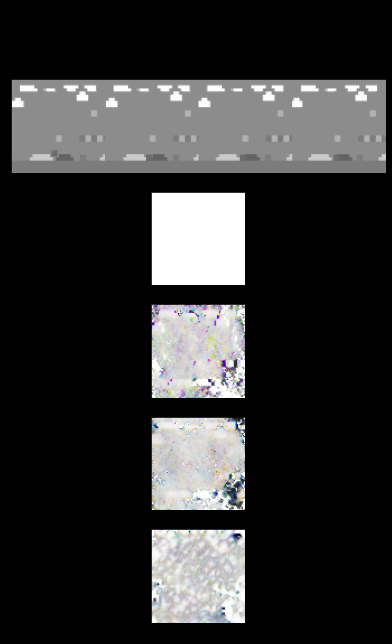

<Figure size 432x288 with 0 Axes>

In [36]:
env, env_name = create_env()

# Apply wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env, keep_dim=False) # Grayscale images
env = ResizeObservation(env, shape=84) # image dim: [84, 84]
env = FrameStack(env, num_stack=4) # 4 frames at a time
obs = (4, 84, 84)

model = ACNetwork(obs, env.action_space.n)
model_eps = '100k'
model_path = f'checkpoints/a2c/a2c_rollout10_ep{model_eps}.pt'
print(f"Loading A2C model from checkpoint: {model_path}")
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model'])
print("Model Loaded, Ensuring weights setup for cuda")
model.cuda()
print("Evaluating model ready for CNN Feature Visualisation")
model.eval()
model_cnn = model.conv
print(model_cnn)

# Frames
input_img_path = 'input_frame_stacks'
frames = [
    (42, "Jumping Over Goomba"),
    # (70, "Jumping Over Pipe"),
    # (108,"Falling In-front Of Goomba (In Air)"),
    # (111,"Falling In-front Of Goomba"),
    # (230,"Stuck On Pipe"),
    # (233,"Stuck On Pipe (In Air)")
]

# visualise_cnn_layers
n_step = 32 #512
conv_layers = [('0', 32, 0), ('2', 32, 1), ('7', 64, 2)] # (layer_idx, features, conv_layer_idx)
for frame_idx, desc in frames:
    frame_path = os.path.join(input_img_path, f"frame_{frame_idx}.png")
    visualise_cnn_layers(frame_path, model_cnn, conv_layers, device, n_step, desc, f"out/A2C/{model_eps}ep_layers-only_{n_step}-steps_frame-{frame_idx}")

env.close()

## DQN

Loading DQN model from checkpoint: checkpoints/dqn/mario_net_12.chkpt
Loading model at checkpoints/dqn/mario_net_12.chkpt with exploration rate 0.11943293650685695
Model Loaded, Evaluating model ready for CNN Feature Visualisation
Sequential(
  (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1024, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=3, bias=True)
)
Generating Activation Image For Layer-0


  0%|          | 0/512 [00:00<?, ?it/s]/home/whiffingj/bin/anaconda3/envs/rl_vis/lib/python3.9/site-packages/lucent/optvis/render.py:103: UserWarning: Some layers could not be computed because the size of the image is not big enough. It is fine, as long as the noncomputed layers are not used in the objective function(exception details: 'mat1 and mat2 shapes cannot be multiplied (2x16384 and 1024x128)')
  warnings.warn(
100%|██████████| 512/512 [00:16<00:00, 31.89it/s]


Generating Activation Image For Layer-2


100%|██████████| 512/512 [00:10<00:00, 47.66it/s]


Generating Activation Image For Layer-5


100%|██████████| 512/512 [00:10<00:00, 47.51it/s]


Generating Activation Image For Layer-7


100%|██████████| 512/512 [00:10<00:00, 47.48it/s]


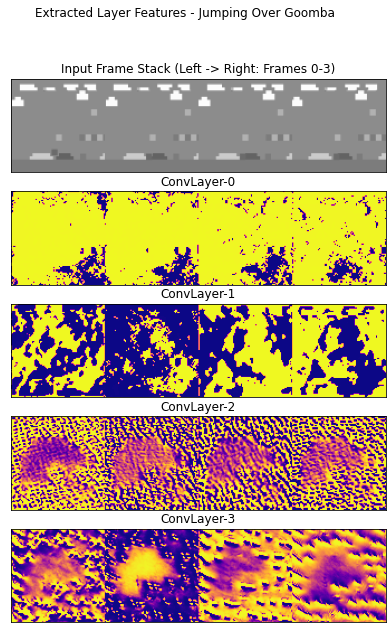

Generating Activation Image For Layer-0


100%|██████████| 512/512 [00:10<00:00, 49.38it/s]


Generating Activation Image For Layer-2


100%|██████████| 512/512 [00:10<00:00, 47.57it/s]


Generating Activation Image For Layer-5


100%|██████████| 512/512 [00:10<00:00, 47.62it/s]


Generating Activation Image For Layer-7


100%|██████████| 512/512 [00:11<00:00, 46.30it/s]


<Figure size 432x288 with 0 Axes>

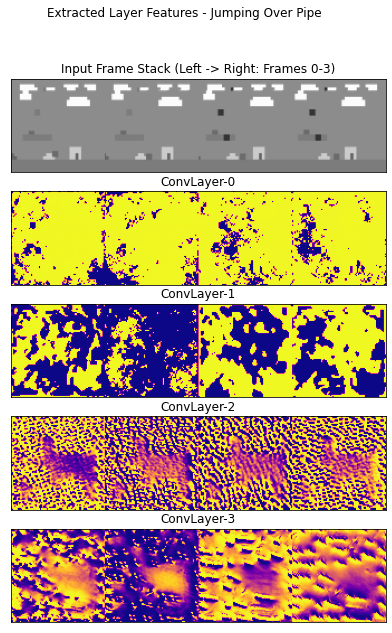

Generating Activation Image For Layer-0


100%|██████████| 512/512 [00:10<00:00, 50.05it/s]


Generating Activation Image For Layer-2


100%|██████████| 512/512 [00:10<00:00, 48.24it/s]


Generating Activation Image For Layer-5


100%|██████████| 512/512 [00:10<00:00, 48.90it/s]


Generating Activation Image For Layer-7


100%|██████████| 512/512 [00:10<00:00, 48.19it/s]


<Figure size 432x288 with 0 Axes>

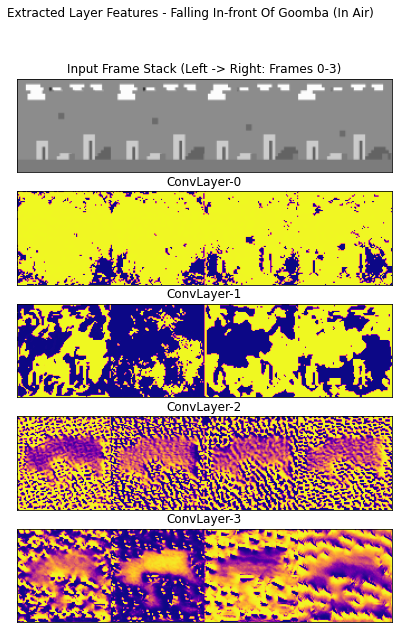

Generating Activation Image For Layer-0


100%|██████████| 512/512 [00:10<00:00, 49.89it/s]


Generating Activation Image For Layer-2


100%|██████████| 512/512 [00:10<00:00, 48.38it/s]


Generating Activation Image For Layer-5


100%|██████████| 512/512 [00:10<00:00, 48.15it/s]


Generating Activation Image For Layer-7


100%|██████████| 512/512 [00:10<00:00, 46.69it/s]


<Figure size 432x288 with 0 Axes>

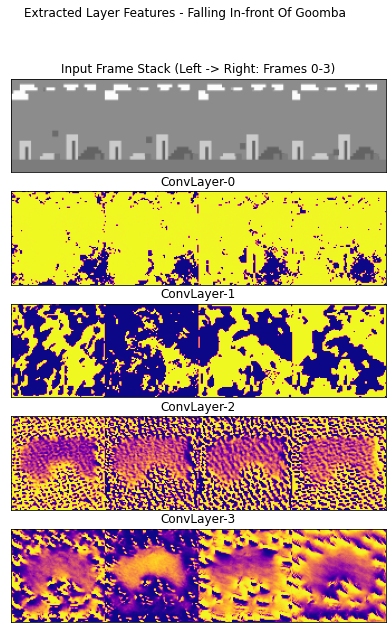

Generating Activation Image For Layer-0


100%|██████████| 512/512 [00:10<00:00, 50.78it/s]


Generating Activation Image For Layer-2


100%|██████████| 512/512 [00:10<00:00, 47.21it/s]


Generating Activation Image For Layer-5


100%|██████████| 512/512 [00:10<00:00, 49.23it/s]


Generating Activation Image For Layer-7


100%|██████████| 512/512 [00:11<00:00, 46.28it/s]


<Figure size 432x288 with 0 Axes>

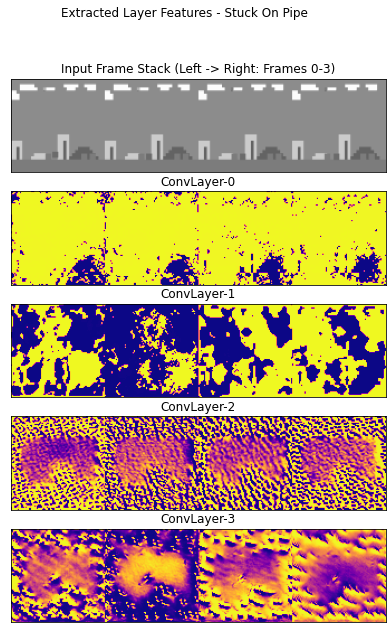

Generating Activation Image For Layer-0


100%|██████████| 512/512 [00:10<00:00, 48.83it/s]


Generating Activation Image For Layer-2


100%|██████████| 512/512 [00:10<00:00, 46.79it/s]


Generating Activation Image For Layer-5


100%|██████████| 512/512 [00:10<00:00, 47.94it/s]


Generating Activation Image For Layer-7


100%|██████████| 512/512 [00:10<00:00, 47.73it/s]


<Figure size 432x288 with 0 Axes>

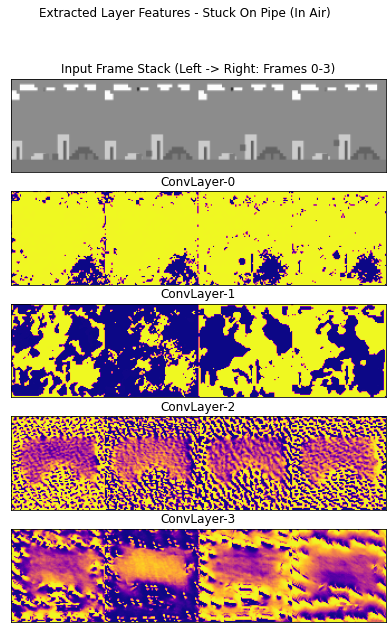

<Figure size 432x288 with 0 Axes>

In [4]:
movement = [['right'],
    ['right', 'A'],
    ['NOOP']]
env, env_name = create_env(movement=movement)
env = SkipFrame(env, skip=4)
env = ResizeObservation(env, shape=84) # image dim: [84, 84]
env = GrayScaleObservation(env, keep_dim=False) # Grayscale images
env = FrameStack(env, num_stack=4) # 4 frames at a time
obs = (4, 84, 84)

model_chpt = '12'
model_path = f'checkpoints/dqn/mario_net_{model_chpt}.chkpt'
print(f"Loading DQN model from checkpoint: {model_path}")
model = Mario(state_dim=obs, action_dim=env.action_space.n, save_dir=".")
path = Path(model_path)
model.load(path)
print("Model Loaded, Evaluating model ready for CNN Feature Visualisation")
model.net.eval()
model_cnn = model.net.online # online_features for new DQN algo (pending checkpoints)
print(model_cnn)

# Frames
input_img_path = 'input_frame_stacks'
frames = [
    (42, "Jumping Over Goomba"),
    (70, "Jumping Over Pipe"),
    (108,"Falling In-front Of Goomba (In Air)"),
    (111,"Falling In-front Of Goomba"),
    (230,"Stuck On Pipe"),
    (233,"Stuck On Pipe (In Air)")
]

# visualise_cnn_layers
conv_layers = [('0', 32, 0), ('2', 32, 1), ('5', 64, 2), ('7', 64, 3)] # (layer_idx, features, conv_layer_idx)

# # visualise_cnn_layers
n_step = 512
for frame_idx, desc in frames:
    frame_path = os.path.join(input_img_path, f"frame_{frame_idx}.png")
    visualise_cnn_layers(frame_path, model_cnn, conv_layers, device, n_step, desc, f"out/DQN/{model_chpt}chpt_layers-only_{n_step}-steps_frame-{frame_idx}")

env.close()